In [1]:

# Import libraries

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

2021-07-25 17:14:46.085963: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


In [2]:
# Specify paths to the training and validation dataset directories

train_path = 'dataset3/train'
#val_path = 'validation dataset directory'

train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
#val_datagen = ImageDataGenerator(rescale=1/255)

target_size = (224,224)

In [3]:
# Generate batches of tensor image data for training

train_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical')

Found 6141 images belonging to 3 classes.


In [4]:
# Generate batches of tensor image data for validation

val_data_gen = train_datagen.flow_from_directory(train_path,
                                               target_size=target_size,
                                               batch_size=32,
                                               class_mode='categorical',
                                               shuffle=False,
                                               subset='validation')


Found 1226 images belonging to 3 classes.


In [5]:
# Filter warnings

import warnings
warnings.filterwarnings('ignore')

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


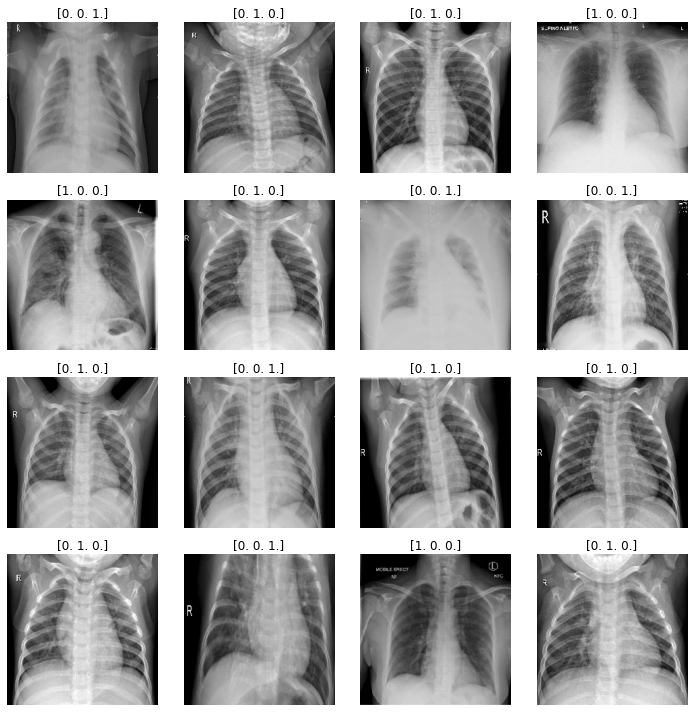

In [6]:
# Visualize samples of training images

class_labels = train_data_gen.class_indices
print(class_labels)

sample_training_images, labels = next(train_data_gen)

def plotImages(images_arr, labels):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.flatten()
    for img, lbs, ax in zip( images_arr, labels, axes):
        ax.imshow(img)
        ax.set_title(lbs)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(sample_training_images[:16], labels[:16])

In [7]:
# Import the Resnet model
from tensorflow.keras.applications.mobilenet import MobileNet

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D


In [9]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [10]:
# Define your pre-trained model

input_shape = (224,224,3)
pretrained_model = MobileNet(input_shape = input_shape,
                weights = 'imagenet',
                #layers=tf.keras.layers,
                include_top = False)
pretrained_model.trainable = False

2021-07-25 17:15:54.150187: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-25 17:15:54.210005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-25 17:15:54.210741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 960M computeCapability: 5.0
coreClock: 1.176GHz coreCount: 5 deviceMemorySize: 1.96GiB deviceMemoryBandwidth: 74.65GiB/s
2021-07-25 17:15:54.210810: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-25 17:15:54.235614: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-25 17:15:54.235737: I tensorflow/stream_executor/platform/def

In [12]:
# Make all the layers untrainable 

for layer in pretrained_model.layers:
    layer.trainable = False

In [13]:
# Define your model

model = Sequential()

model.add(pretrained_model)

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(3))
model.add(Activation('softmax'))
model.build((None, 224, 224, 3 ))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dropout (Dropout)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 150531    
_________________________________________________________________
activation (Activation)      (None, 3)                 0         
Total params: 3,379,395
Trainable params: 150,531
Non-trainable params: 3,228,864
_________________________________________________________________


In [14]:
# Define early stopping and model checkpoint for optimizing epoch number and saving the best model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
patience=20)

mc = ModelCheckpoint('covid_19_resnet1.h5', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [15]:
# Compile and fit your model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 20
with tf.device('/gpu:0'):
    history = model.fit_generator(train_data_gen,
                              epochs=epochs,
                              validation_data=val_data_gen )

2021-07-25 17:17:00.038693: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2021-07-25 17:17:00.123572: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-25 17:17:00.142846: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2599990000 Hz


Epoch 1/20


2021-07-25 17:17:02.152113: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2021-07-25 17:17:02.171832: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2021-07-25 17:17:02.922151: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200
2021-07-25 17:17:03.474357: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.
2021-07-25 17:17:04.006508: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2021-07-25 17:17:05.073187: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2021-07-25 17:17:05.291190: W tensorflow/core/common_runtime/bfc_allocator.cc:337] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a 

  1/192 [..............................] - ETA: 17:49 - loss: 4.0662 - accuracy: 0.1250

2021-07-25 17:17:05.679606: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.18GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  3/192 [..............................] - ETA: 1:09 - loss: 4.7273 - accuracy: 0.5000

2021-07-25 17:17:06.378335: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


  4/192 [..............................] - ETA: 1:31 - loss: 3.9561 - accuracy: 0.5703

2021-07-25 17:17:07.089934: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 19267584 exceeds 10% of free system memory.


 45/192 [======>.......................] - ETA: 1:48 - loss: 1.9397 - accuracy: 0.8566

2021-07-25 17:17:38.091711: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


192/192 [==============================] - 175s 888ms/step - loss: 0.8585 - accuracy: 0.9306 - val_loss: 0.0357 - val_accuracy: 0.9927


2021-07-25 17:19:55.397068: W tensorflow/core/common_runtime/bfc_allocator.cc:271] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


Epoch 2/20
192/192 [==============================] - 169s 880ms/step - loss: 0.2955 - accuracy: 0.9707 - val_loss: 0.0454 - val_accuracy: 0.9935
Epoch 3/20
192/192 [==============================] - 166s 862ms/step - loss: 0.1570 - accuracy: 0.9845 - val_loss: 2.0378e-04 - val_accuracy: 1.0000
Epoch 4/20
192/192 [==============================] - 163s 850ms/step - loss: 0.1658 - accuracy: 0.9852 - val_loss: 0.0549 - val_accuracy: 0.9910
Epoch 5/20
192/192 [==============================] - 161s 838ms/step - loss: 0.1840 - accuracy: 0.9832 - val_loss: 0.0035 - val_accuracy: 0.9992
Epoch 6/20
192/192 [==============================] - 162s 844ms/step - loss: 0.1698 - accuracy: 0.9879 - val_loss: 0.2837 - val_accuracy: 0.9755
Epoch 7/20
192/192 [==============================] - 161s 841ms/step - loss: 0.1062 - accuracy: 0.9920 - val_loss: 7.7787e-10 - val_accuracy: 1.0000
Epoch 8/20
192/192 [==============================] - 163s 849ms/step - loss: 0.1138 - accuracy: 0.9914 - val_loss: 

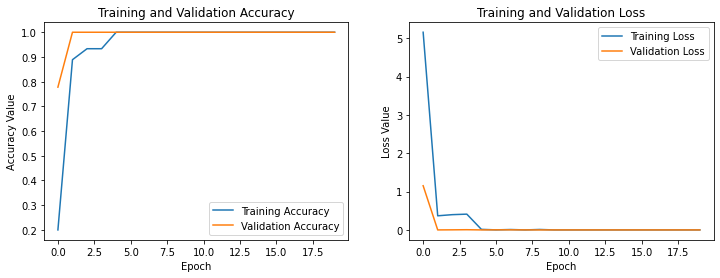

In [28]:
# Plot accuracy and loss for testing and validation

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

#trying to print the accuresy.

print(history.history.keys())

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss Value')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# Evaluate your model with confusion matrix and classification report

class_labels = train_data_gen.class_indices
print(class_labels)
print('\n')

from sklearn.metrics import classification_report, confusion_matrix

Y_pred = model.predict_generator(val_data_gen, val_data_gen.samples // val_data_gen.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix \n')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('\n')
print('Classification Report \n')
target_names = ['COVID-19', 'Normal','Pneumonia-Viral']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

{'COVID-19': 0, 'Normal': 1, 'Pneumonia-Viral': 2}


Confusion Matrix 

[[3 0 0]
 [0 3 0]
 [0 0 3]]


Classification Report 

                 precision    recall  f1-score   support

       COVID-19       1.00      1.00      1.00         3
         Normal       1.00      1.00      1.00         3
Pneumonia-Viral       1.00      1.00      1.00         3

       accuracy                           1.00         9
      macro avg       1.00      1.00      1.00         9
   weighted avg       1.00      1.00      1.00         9

